# Anaylsis Bike Sharing Data

In [179]:
import numpy as np
import pandas as pd
import datetime
import matplotlib as plt
%matplotlib inline
from sqlalchemy import create_engine
import requests
import time

import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin

### Datasets

- Raw data: raw.csv

- Categorized in Trip and accessible: preprocessed.csv

- Cleaned according to plausability: cleaned.csv

- routed routed.csv

- Trip Dataset: pseudonomysed.csv
    - pseudonomysed
    - trip ID, start time, end time, start location, stop location, duration, estimated distance<

# Preprocessing

## get data from database

In [ ]:
dbhost = ''
dbname = ''
dbuser = ''
dbpassword = ''

In [ ]:
sql = """
select *
from (
    select  "bikeId", "providerId", "timestamp", latitude, longitude,
			lag("bikeId") over (order by "bikeId" ASC, "timestamp" ASC) as prev_id,
            lead("bikeId") over (order by "bikeId" ASC, "timestamp" ASC) as next_id,
            lag("latitude") over (order by "bikeId" ASC, "timestamp" ASC) as prev_lat,
			lag("longitude") over (order by "bikeId" ASC, "timestamp" ASC) as prev_lon,
            lead("latitude") over (order by "bikeId" ASC, "timestamp" ASC) as next_lat,
            lead("longitude") over (order by "bikeId" ASC, "timestamp" ASC) as next_lon
    from public."bikeLocations"
    )x
	where ("bikeId" <> next_id) or
		   ("bikeId" <> prev_id) or
		   (latitude <> next_lat or longitude <> next_lon or latitude <> prev_lat or longitude <> prev_lon)
	
	--keep first and last instance of bike (bikeId <> prev_id or bikeId <> next_id)
	--keep all changes inbetween, where bike_Id is equal to next_id but lat or lon changed to prev or next
"""

engine = create_engine('postgresql://' + dbuser + ':' + dbpassword + '@' + dbhost + ':5432/' + dbname)
df = pd.read_sql_query(sql,con=engine)

In [ ]:
# df.to_csv('../../data/raw.csv', index_label= 'id')

## preprocess

In [169]:
df = pd.read_csv('../../data/raw.csv', parse_dates=['timestamp'])

In [170]:
# correct wrong lat lons 
# get mode (trip or is bike accessible)

def preprocess(df):
    
    # for a certain period the lat lon of one provider were stored the wrong way 
    # switch lat lon where it's wrong (for Berlin)
    temp = df.loc[(df.longitude > 40),'latitude'].copy(deep=True)

    df.loc[(df.longitude > 40),'latitude'] = df.loc[(df.longitude > 40),'longitude']
    df.loc[(df.longitude > 40),'longitude'] = temp
    
    temp0 = df.loc[(df.next_lon > 40),'next_lat'].copy(deep=True)

    df.loc[(df.next_lon > 40),'next_lat'] = df.loc[(df.next_lon > 40),'next_lon']
    df.loc[(df.next_lon > 40),'next_lon'] = temp0
    
    temp1 = df.loc[(df.prev_lon > 40),'prev_lat'].copy(deep=True)
    
    df.loc[(df.prev_lon > 40),'prev_lat'] = df.loc[(df.prev_lon > 40),'prev_lon']
    df.loc[(df.prev_lon > 40),'prev_lon'] = temp1
    
    MODE_TRIP = 'trip'
    MODE_ACCESS = 'accessible'

    df['end_timestamp'] = None
    df['mode'] = None

    df.sort_values(by=['bikeId', 'timestamp'], inplace = True)
    df['end_timestamp'] = df.timestamp.shift(-1)
    
    df['next_lat'] = np.where(df.bikeId == df.bikeId.shift(-1), df.latitude.shift(-1), -1)\n
    df['next_lon'] = np.where(df.bikeId == df.bikeId.shift(-1), df.longitude.shift(-1), -1)\n

    # if the bike has moved its a trip, otherwise the bike was accessible at its location
    # round to 3 digits for lat lon (trip should be longer than approx. 100 meters)
    df['mode'] = np.where((df.latitude.round(3) != df.next_lat.round(3)) | (df.longitude.round(4) != df.next_lon.round(4)), MODE_TRIP, MODE_ACCESS)
    
    # if bike Id is not the same as next, then this is the final time stamp and the next_timestamp is set to None
    df['end_timestamp'] = df.end_timestamp.where(df.bikeId == df.bikeId.shift(-1),None, axis=0)
    
    # delete last instances of all bikes
    df = df[df.next_lat.notnull()]
    
    return df

In [171]:
df = preprocess(df)

In [172]:
df.to_csv('../../data/preprocessed.csv', index_label= 'id')

## Routing

In [180]:
def routing(start_lon, start_lat, end_lon, end_lat):
    start = str(start_lon) + ',' + str(start_lat)
    end = str(end_lon) + ',' + str(end_lat)
    params = {'start':start,
              'end':end,
              'modal':'bicycle'
             }
    r = requests.get('http://localhost:1717/route', params = params)
    response = r.json()
    return response

In [181]:
df = pd.DataFrame()
for chunk in pd.read_csv('../../data/preprocessed.csv', index_col='id', parse_dates=['timestamp', 'end_timestamp'],chunksize=100000):
    start = time.time()
    chunk['response'] = None
    chunk['geometry'] = None
    chunk['distance'] = None
    chunk['calc_time'] = None
    chunk['waypoints'] = None
    
    # only do routing for trips
    selection = (chunk['mode']=='trip') & (chunk.next_lat.notnull())
    chunk.loc[selection, 'response'] = chunk.loc[selection].apply(lambda row: routing(row.longitude, row.latitude, row.next_lon, row.next_lat), axis=1)
    chunk.loc[selection, 'geometry'] = chunk.loc[selection]['response'].apply(lambda row: row['routes'][0]['geometry'])
    chunk.loc[selection, 'distance'] = chunk.loc[selection]['response'].apply(lambda row: row['routes'][0]['distance'])
    chunk.loc[selection, 'calc_time'] = chunk.loc[selection]['response'].apply(lambda row: row['routes'][0]['duration'])
    chunk.loc[selection, 'waypoints'] = chunk.loc[selection]['response'].apply(lambda row: row['waypoints'])
    end = time.time()
    print(end - start)
    df = df.append(chunk)

214.57879996299744
223.48249912261963
214.69404888153076
189.998055934906
177.86353087425232
178.07002592086792
178.5570878982544
490.3402931690216
514.6639800071716
230.62421798706055
204.9859230518341
166.9845311641693
173.87214183807373
163.3482518196106
156.35346794128418
154.9044930934906
168.71858096122742
179.56365704536438
154.8981430530548
153.71806001663208
161.40800881385803
160.61402201652527
484.7227940559387
165.4938759803772
144.62416791915894
160.95510387420654
188.71538925170898
160.1147141456604
156.14063096046448
145.88051581382751
151.20413494110107
5570.233852863312
168.08731317520142
156.1642780303955
168.08376622200012
180.47953414916992
164.22090196609497
177.3228931427002
9975.520352125168
155.88235807418823
154.1496877670288
146.9719421863556
1111.4445898532867
161.26306581497192
165.64914107322693
157.92316102981567
171.8003692626953
163.10643601417542
150.91775488853455
175.11917686462402
0.3518679141998291


In [182]:
# df.to_csv('../../data/routed.csv')

In [115]:
# df.to_json('../../data/routed.json')

## Pseudonomysation of uncleaned data

In [ ]:
# df = pd.read_csv('../../data/routed.csv', parse_dates=['timestamp','end_timestamp'])

In [87]:
# pseudonomoysed
pseudon = df.copy(deep=True)
pseudon['starttime'] = pseudon.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))
pseudon['endtime'] = np.where(pseudon.end_timestamp.isnull(), None, pseudon.end_timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15))))
pseudon.reset_index()
pseudon.latitude = pseudon.latitude.round(3)
pseudon.longitude = pseudon.longitude.round(3)
pseudon.next_lat = pseudon.next_lat.round(3)
pseudon.next_lon = pseudon.next_lon.round(3)
pseudon = pseudon[pseudon['mode'] == 'trip'].drop(['providerId', 'bikeId', 'timestamp', 'end_timestamp', 'next_id','prev_id', 'mode', 'prev_lat', 'prev_lon', 'response', 'calc_time','geometry', 'waypoints'], axis=1).copy(deep=True)

In [88]:
# pseudon.to_csv('../../data/pseudonomysed.csv', index_label='id')

## Data Cleaning

In [160]:
# df = pd.read_csv('../../data/routed.csv', parse_dates=['timestamp','end_timestamp'])

In [183]:
def cleaning(df):
    df['duration'] = df.end_timestamp - df.timestamp
    df['speed'] = np.where(df.distance.notnull(), ((df.distance/1000) / (df.duration.apply(lambda x: x.total_seconds()/3600))), None)
 
    # delete instances with unplausible locations (outside of Berlin)
    df.drop(df[df.longitude > 13.8].index, inplace=True)
    df.drop(df[df.next_lon > 13.8].index, inplace=True)

    df.drop(df[df.longitude < 13.0].index, inplace=True)
    df.drop(df[df.next_lon < 13.0].index, inplace=True)

    df.drop(df[df.latitude > 52.7].index, inplace=True)
    df.drop(df[df.next_lat > 52.7].index, inplace=True)

    df.drop(df[df.latitude < 52.3].index, inplace=True)
    df.drop(df[df.next_lat < 52.3].index, inplace=True)

    
    # Check for unplausible data
    
    # drop trips that are longer than 24 hours
    df = df.drop(df[(df['mode'] == 'trip') & (df.duration > datetime.timedelta(hours=24))].index)

    # drop trips before 1.4.2019 
    df = df.drop(df[df['timestamp'] <  pd.Timestamp(2019,4,1)].index)
    
    # drop trips that are smaller than 100 m or faster than 30 km/h
    df = df[(df['mode']=='accessible')|((df.distance > 100) & (df.speed < 30))]
    
    return df

In [184]:
df = cleaning(df)

In [ ]:
# TODO: drop all last occurencies

In [286]:
ids = df.sort_values(by=['bikeId', 'timestamp']).groupby('bikeId').last()['id.1']

In [306]:
df = df.drop(ids.tolist())

In [307]:
df.to_csv('../../data/cleaned.csv', index_label = 'id')

## Pseudonymisation of cleaned data

https://datasmart.ash.harvard.edu/news/article/civic-analytics-network-dockless-mobility-open-letter

https://data.louisvilleky.gov/dataset/dockless-vehicles

In [308]:
# pseudonomoysed cleaned
pseudon = df.copy(deep=True)
pseudon['starttime'] = pseudon.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))
pseudon['endtime'] = np.where(pseudon.end_timestamp.isnull(), None, pseudon.end_timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15))))
pseudon.reset_index()
pseudon.latitude = pseudon.latitude.round(3)
pseudon.longitude = pseudon.longitude.round(3)
pseudon.next_lat = pseudon.next_lat.round(3)
pseudon.next_lon = pseudon.next_lon.round(3)
pseudon = pseudon[pseudon['mode'] == 'trip'].drop(['providerId', 'bikeId', 'timestamp', 'end_timestamp', 'next_id','prev_id', 'mode', 'prev_lat', 'prev_lon', 'response', 'calc_time','geometry', 'waypoints'], axis=1).copy(deep=True)

In [309]:
pseudon.to_csv('../../data/pseudonomysed_clean.csv', index_label='id')

# Analysis

In [ ]:
# df = pd.read_csv('../../data/cleaned.csv', parse_dates=['timestamp','end_timestamp', 'duration'])

In [312]:
df['mode'].value_counts()

accessible    2965188
trip           661064
Name: mode, dtype: int64

In [ ]:
df.duration = df.end_timestamp - df.timestamp

In [ ]:
dist = df[df.distance.notnull()]

In [ ]:
dist.groupby('providerId').distance.describe()

In [ ]:
dist[dist.distance > 100].distance.hist(range=(200, 2000))

In [ ]:
#dist[dist.distance > 200].distance.value_counts()

In [ ]:
dist[dist.distance > 100].describe()

In [ ]:
dist[dist.distance < 100].shape

In [ ]:
dist[dist.duration > datetime.timedelta(minutes=5)].describe()

In [ ]:
dist[dist.distance > 100].groupby('providerId').duration.describe()

In [ ]:
df[df['mode'] == 'trip'].duration.describe()

In [ ]:
# histogram of minutes spent on trip
df.duration.apply(lambda x: x.seconds / 60).hist(range=(0,250))

In [ ]:
# average duration of trips and accesible quases

In [ ]:
df[df['mode'] == 'trip'].duration.describe()

In [ ]:
df[df['mode'] == 'accessible'].duration.describe()

In [ ]:
dist.loc[:,'hourly_starttime'] = dist.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 60)))

In [ ]:
dist

In [ ]:
counts = dist[dist.distance > 100][['bikeId', 'hourly_starttime']].groupby(['hourly_starttime']).count()

In [ ]:
counts[100:300].plot(figsize=(20,10))

### original data

#### How many unique bike IDs are there (per provider)?

In [ ]:
# how many bikes are available / on a trip for each hour?
def get_unique_ids_per_day(df):
    daily_unique = pd.DataFrame()

    start_time = df.sort_values('timestamp').reset_index().loc[0,'timestamp']
    end_time = df.sort_values('timestamp').reset_index().loc[df.shape[0]-2, 'timestamp']
    times= []
    
    # get all desired times
    while start_time < end_time:
        times.append(start_time)
        start_time += datetime.timedelta(hours=24)
    
    daily_unique['time'] = times
    daily_unique['total'] = daily_unique.time.apply(lambda x: df[
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['nextbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 0)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['lidlbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 1)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['mobike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 2)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    
    return daily_unique
    

In [ ]:
def get_unique_ids(df):
    unique_bikes = pd.DataFrame()
    unique_bikes = unique_bikes.append([([df.bikeId.unique().shape[0], df[(df.providerId == 0)].bikeId.unique().shape[0], 
             df[(df.providerId == 1)].bikeId.unique().shape[0],
             df[(df.providerId == 2)].bikeId.unique().shape[0]])])
    unique_bikes.columns = [['total', 'nextbike', 'lidlbike', 'mobike']]
    return unique_bikes

In [ ]:
daily_uniques = get_unique_ids_per_day(df)

In [ ]:
daily_uniques.describe()

In [ ]:
uniques = get_unique_ids(df)
uniques

In [ ]:
# average trips per bike
df_trips = df[df['mode']=='trip']
df_trips.groupby(['bikeId', 'providerId']).count().groupby('providerId').describe()

#### How much time is a bike used? 

#### how high is the utilization rate? (available bikes / all bikes)

In [ ]:
# how many bikes are available / on a trip for each hour?
def count_bikes_in_mode(df, mode):
    bikes_accessible = pd.DataFrame()

    start_time = df.sort_values('timestamp').reset_index().loc[0,'timestamp']
    end_time = df.sort_values('timestamp').reset_index().loc[df.shape[0]-2, 'timestamp']
    times= []
    while start_time < end_time:
        times.append(start_time)
        start_time += datetime.timedelta(hours=36)
    
    bikes_accessible['time'] = times
    bikes_accessible['total'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['nextbike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 0)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['lidlbike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 1)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['mobike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 2)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    return bikes_accessible
    

In [ ]:
accessible = count_bikes_in_mode(df.sort_values('timestamp'), 'accessible')

In [ ]:
in_use = count_bikes_in_mode(df.sort_values('timestamp'), 'trip')

In [ ]:
in_use.median()

In [ ]:
accessible.median()

In [ ]:
# still that high when cleaned??

In [ ]:
in_use.median() / accessible.median()

#### Bike Availability: 
- Where are bikes available (per Planungsraum)? On average? On average weekdays / times?
- Distance between available bikes

#### how long is the life span of a bike? (first appearence and last appearence)
- is there periodical appearences?

In [ ]:
# get data for lifespan

def lifespan (df):
    # each line one trip with start-loc and end-loc
    # for each bike ID
    start_timestamp = df.sort_values(by=['bikeId', 'timestamp']).drop_duplicates('bikeId', keep='first')
    last_timestamp = df.sort_values(by=['bikeId', 'timestamp'], ascending = False).drop_duplicates('bikeId', keep='first')
    start_timestamp.set_index('bikeId', inplace=True)
    last_timestamp.set_index('bikeId', inplace=True)
    return start_timestamp.join(last_timestamp[['timestamp']], rsuffix='_last')

#df_lifespan = pd.DataFrame()
#chunksize = 10 ** 8
#for chunk in pd.read_csv('raw_small.csv', chunksize=chunksize):
    #df_lifespan = df_lifespan.append(lifespan(chunk))
    
df_lifespan = lifespan(df)

#df_lifespan.to_csv('lifespan.csv')

In [ ]:
df[['bikeId', 'providerId']].drop_duplicates().groupby('providerId').count()

#### where are bikes "moved"? (e.g. very fast rides by car)

In [ ]:
dist['speed'] = (dist.distance/1000) / (dist.duration.apply(lambda x: x.total_seconds()/3600))

In [ ]:
dist['speed'].apply(lambda x: round(x, 0)).value_counts().hist(range=(0,10))

In [ ]:
#dist[dist.speed > 20]

In [ ]:
dist['speed'].describe()

## pseudonomysed trip data

In [ ]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf = gdf.to_crs(epsg=25833)

In [ ]:
geometry = [Point(xy) for xy in zip(df.next_lon, df.next_lat)]
gdf_end = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf_end = gdf_end.to_crs(epsg=25833)

In [ ]:
berlin = geopandas.read_file('lor_planungsraeume.geojson')
berlin = berlin.to_crs(epsg=25833)

In [ ]:
# map of accessible bikes
base = berlin.plot(color='white', edgecolor='black', figsize=(20,20))
gdf[(gdf['mode']=='accessible') & (gdf.latitude > 52.3) & (gdf.longitude > 13.0)& (gdf.latitude < 53.7) & (gdf.longitude < 13.7)].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map of startpoints
gdf[(gdf['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map of endpoints
gdf_end[(gdf_end['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map both
start = gdf[(gdf['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20), color='red')
gdf_end[(gdf_end['mode']=='trip')].plot(ax=start, markersize=0.01, figsize=(20,20))

In [ ]:
# heatmap (?)
import geoplot
ax = geoplot.kdeplot(gdf.head(100),
                     shade=True, shade_lowest=False,
                     clip=boroughs.geometry)
geoplot.polyplot(boroughs, ax=base)

#### How many bikes are in use at what point in time (weekday)?

In [161]:
# hour of day
df['hour_of_day'] = df.timestamp.apply(lambda x: x.time().hour)

In [167]:
# day of week
df['day_of_week'] = df.timestamp.apply(lambda x: x.weekday())

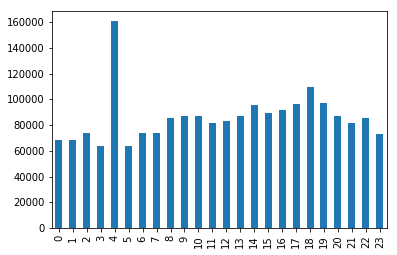

In [165]:
df.hour_of_day[df['mode']=='trip'].value_counts().sort_index().plot(kind='bar')

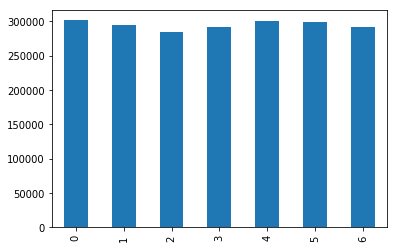

In [168]:
df.day_of_week[df['mode']=='trip'].value_counts().sort_index().plot(kind='bar')

In [ ]:
# see whole time on hourly / daily basis

In [ ]:
df.loc[:,'hourly_starttime'] = df.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 60)))

In [ ]:
df[df['mode']=='trip'].hourly_starttime.describe()

In [ ]:
# moving of bikes at 4am??

In [ ]:
# amount of trips
counts = df[(df['mode'] == 'trip')& df.providerId == 1][['bikeId', 'hourly_starttime']].groupby(['hourly_starttime']).count()

In [ ]:
counts.plot()

In [ ]:
df.loc[:,'daily_starttime'] = df.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))

In [ ]:
counts = df[(df['mode'] == 'trip')& df.providerId == 1][['bikeId', 'daily_starttime']].groupby(['daily_starttime']).count()

In [ ]:
df[df.providerId == 1].sort_values('timestamp')

#### How many rides are there per day?

#### How long is the average ride (time and length)? How fast?

## Geoanalysis 

In [ ]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf_data = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf = gpd.read_file('lor_planungsraeume.geojson')

In [ ]:
pointInPolys = sjoin(gdf_data.head(), gdf, how='left')

In [ ]:
gdf_data.intersects(gdf.unary_union)

In [ ]:
gpd.overlay(gdf, gdf_data)

#### Where are most rides? (Bezirk, ...) Heatmap

In [ ]:
# cross with Planungsräume

gdf.rename(index=str, columns={"spatial_name": "cell_id"}, inplace=True)
gdf[['cell_id', 'geometry']].to_file('planungsraeume.json', driver='GeoJSON')
df = pd.DataFrame(gdf)[['cell_id', 'geometry']]
gdf.set_index('cell_id', inplace=True)
gdf['geometry'].to_file('test2.json', driver='GeoJSON', index='False')
f= open("test.json","w")
f.write(gdf['geometry'].to_json())
f.close()    
test = gdf['geometry'].to_dict()
for key, values in test.items():
    print (key)
test = pd.read_json('test.json', orient='records')

#### What are highly frequented routes? (Are there good bike lanes? Should there be better bike lanes?)

#### Are there "hot spots" for pick up and drop off?

## Include further data

#### Intersect with subway stops

#### weather data

#### nextbike stations: with and without docking station: how many rides start from / end at a docking station